# Spatial Transcriptomics Workshop

Today we're talking about spatial transcriptomics and we're going to use some popular python packages for this type of analysis. These are all part of the "scverse" group of packages which includes anndata, scanpy, and squidpy. They build on each other's functionality: anndata is for "annotated dataframes" which is a useful data type for this work, and then scanpy stands for Single Cell Analysis in PYthon and provides lots of functions for single cell analysis with anndata objects, and squidpy builds on both to add functions for dealing with spatial coordinates and imaging data.

### Software environment for this notebook

I have a virtual environment for running this notebook installed on Quest at `/projects/e32680/haley/sc_env` which you can install an ipykernel into to use with Jupyter. To do so:

```bash
conda activate /projects/e32680/haley/sc_env # might have to load a module if you don't have conda available
which python # should point to python in this location
python -m ipykernel install --user --name sc_env --display-name="haley-sc_env"
```

If you want to recreate this environment for yourself you could do the following:

If you attended the workshop last week, you have a virtual environment where we installed scanpy as well as scvi-tools which is another popular package for single cell analysis in python that we don't have time to talk about today. I added a few things to this environment for this notebook. Specifially, with the environment activated I used pip to install the following:

```bash
pip install 'spatialdata[extra]'
pip install dask==2024.12.1
pip install 'squidpy[interactive]'
```

If you were not at last week's workshop and are trying to build this environment from scratch you can do the following:

```bash
module purge
module load mamba/24.3.0
mamba init
source ~/.bashrc
module purge

mamba create --name sc_env -c conda-forge python ipykernel ipywidgets
mamba activate sc_env
pip install 'scanpy[leiden]' scvi-tools 'spatialdata[extra]' dask==2024.12.1 'squidpy[interactive]'
python -m ipykernel install --user --name sc_env --display-name="sc_env"
```

## Scanpy and Squidpy Functions

Scanpy functions tend to be denoted either "preprocessing" as `pp`, "tool" as `tl` or "plot" as `pl`. Tools transform the data or calculate something beyond what the scanpy developers consider preprocessing, while plot functions plot something. You'll notice the functions in the "Processing the AnnData Object" section of this notebook are tools and all start with `sc.tl.` followed by the name of the specific function. More usage principles and the application programming interface (API) for this package can be found here: https://scanpy.readthedocs.io/en/stable/usage-principles.html and here: https://scanpy.readthedocs.io/en/stable/api/index.html

Squidpy functions fall into more categories. There are graphing functions, `gr`, functions for dealing with imaging data, `im`, functions for reading in data `read`, or using prebuilt datasets, `datasets`, as well `tl` and `pl`. 

The squidpy API is here: https://squidpy.readthedocs.io/en/stable/api.html

The squidpy definition of a "graph" function is a bit broad and includes many things that I would consider calulations, or tools. For example:

`gr.nhood_enrichment(adata, cluster_key[, ...])`    Compute neighborhood enrichment by permutation test.

`gr.co_occurrence(adata, cluster_key[, ...])`    Compute co-occurrence probability of clusters.


## Importing Libraries and Reading in Data

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
# scanpy uses chained assignment to manipulate pandas dfs, and will throw warnings without the above

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
import squidpy as sq
import seaborn as sns

/projects/e32680/haley/sc_env/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/projects/e32680/haley/sc_env/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:504: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
/projects/e32680/haley/sc_env/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:505: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = partial(_left_exclusive_join_spatialeleme

In [2]:
sc.logging.print_header() # this is for printing logging information, not working well though
print(f"squidpy=={sq.__version__}")

squidpy==1.6.2


There are some FutureWarnings when importing these packages that are ok to ignore for now. Some of these are because there was a recent update to the package called Dask that scanpy is still integrating.

We're going to use a spatial transcriptomic dataset that is available from squidpy and that is used in their tutorials. It is a Visium slide of a coronal section of the mouse brain. You can read more about it in their tutorial here: https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_visium_hne.html

The functions to load the preprocessed data is below, where img is the image file and adata is the sequencing data.

In [2]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

Let's take a 'look' at each of these...

In [4]:
img

ImageContainer[shape=(11757, 11291), layers=['image']]

This is the imaging data, Visium provides high-resolution images of the tissue that was used for the gene extraction. Squidpy has some functionality for annotation image layers as well as the expression data but we won't have time to cover that today.

In [5]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

This is the data generated from the sequencing associated with the image file.

# Processing the AnnData Object with Scanpy

The preprocessed data we've read in as 'adata' is a few steps ahead where most people would be starting with their own data, so we're going to backtrack a little and do some of those processing steps ourselves. 

This scanpy tutorial goes more in dept on pre-processing: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

## AnnData Object Structure

As mentioned before, AnnData is for "annotated dataframes" so each AnnData object has a basic dataframe (or actually matrix) and then multiple annotations of that dataframe, some of which are dataframes themselves. 

The basic matrix can be referenced with:

```python
adata.X
```

And other object attributes can be referenced the same way. 

### Let's start with 'obs' and 'var'

In [6]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,leiden,cluster
AAACAAGTATCTCCCA-1,1,50,102,4928,8.502891,19340.0,9.869983,38.428128,43.133402,49.214064,60.449845,3857.0,8.257904,19.943123,19340.0,2,Cortex_2
AAACAATCTACTAGCA-1,1,3,43,3448,8.145840,13750.0,9.528867,50.516364,55.141818,60.952727,70.574545,3267.0,8.091933,23.760000,13750.0,11,Cortex_5
AAACACCAATAACTGC-1,1,59,19,6022,8.703341,32710.0,10.395467,40.483033,47.071232,54.564353,65.087129,4910.0,8.499233,15.010699,32710.0,7,Thalamus_2
AAACAGAGCGACTCCT-1,1,14,94,4311,8.369157,15909.0,9.674704,40.957948,45.810547,52.077440,62.976931,3270.0,8.092851,20.554403,15909.0,11,Cortex_5
AAACCGGGTAGGTACC-1,1,42,28,5787,8.663542,31856.0,10.369013,40.287544,45.887745,52.982170,64.248493,6693.0,8.808967,21.010170,31856.0,7,Thalamus_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,7016,8.856091,34390.0,10.445550,30.994475,37.758069,45.891247,57.321896,4002.0,8.294800,11.637104,34390.0,12,Lateral_ventricle
TTGTTTCACATCCAGG-1,1,58,42,6995,8.853094,44372.0,10.700386,33.284504,40.203281,48.906968,61.421617,5739.0,8.655214,12.933832,44372.0,6,Hypothalamus_1
TTGTTTCATTAGTCTA-1,1,60,30,5082,8.533657,24432.0,10.103690,38.506876,45.640963,53.675508,65.307793,3560.0,8.177796,14.571054,24432.0,6,Hypothalamus_1
TTGTTTCCATACAACT-1,1,45,27,5661,8.641532,27381.0,10.217641,36.886892,42.441839,49.589131,60.998503,5296.0,8.574896,19.341881,27381.0,7,Thalamus_2


These correspond to cells, and the row names are the cell barcodes.

In [7]:
adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
Xkr4,ENSMUSG00000051951,Gene Expression,mm10,False,233,0.093032,0.088955,91.363973,251.0,5.529429,233,False,NaN,0.093378,0.098832,0.815019
Sox17,ENSMUSG00000025902,Gene Expression,mm10,False,298,0.128243,0.120662,88.954781,346.0,5.849325,298,False,NaN,0.128720,0.156108,0.931378
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10,False,1775,1.370645,0.863162,34.210526,3698.0,8.215817,1775,False,NaN,1.375744,2.163193,0.850736
Lypla1,ENSMUSG00000025903,Gene Expression,mm10,False,1294,0.741290,0.554626,52.038547,2000.0,7.601402,1293,False,NaN,0.743676,0.984143,0.873699
Tcea1,ENSMUSG00000033813,Gene Expression,mm10,False,1975,1.727947,1.003549,26.797628,4662.0,8.447414,1974,False,NaN,1.734003,3.030447,0.856292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmlhe,ENSMUSG00000079834,Gene Expression,mm10,False,72,0.027798,0.027419,97.331357,75.0,4.330733,72,False,NaN,0.027902,0.029366,0.888284
Gm10931,ENSMUSG00000094350,Gene Expression,mm10,False,5,0.001853,0.001852,99.814678,5.0,1.791759,5,False,NaN,0.001860,0.001857,0.984078
AC149090.1,ENSMUSG00000095041,Gene Expression,mm10,False,2319,3.296887,1.457891,14.047443,8895.0,9.093357,2318,True,3150.0,3.308780,10.516454,1.096961
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,mm10,False,695,0.320237,0.277811,74.240178,864.0,6.762730,694,False,NaN,0.321057,0.370647,0.850570


These correspond to genes and the row names are gene names. Both of these attributes are pandas dataframes and you can work with them like any other pandas dataframes.

A more basic AnnData object would have fews columns for both obs and var, usually only in_tissue, array_row, and array_col, or gene_ids, feature_types, and genome, respectively.

The rest come from the scanpy function `sc.pp.calculate_qc_metrics()`, which, like the name implies, calcuates QC metrics from these data. The documentation for this function is here: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html#scanpy.pp.calculate_qc_metrics

In [4]:
adata1 = adata
adata1.obs = adata1.obs[["in_tissue", "array_row", "array_col"]]
adata1.var = adata1.var[["gene_ids", "feature_types", "genome"]]
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

The "mt" var that was in the pre-processed data indicates whether or not it is a mitochondrial gene and that information was taken from the gene names:

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata1.var["mt"] = adata1.var_names.str.startswith("MT-")
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
# we could do the same for ribosomal genes
#adata1.var["ribo"] = adata1.var_names.str.startswith(("RPS", "RPL"))
# and for hemoglobin genes
#adata1.var["hb"] = adata1.var_names.str.contains("^HB[^(P)]")
# but we'll leave these commented out so our data matches their processed data

To calculate metrics based on our new 'mt' variable we use `calculate_qc_metrics` indicating the data, the variable, and then `inplace=True` updates our existing adata1's obs and var instead of creating a new object.

In [6]:
sc.pp.calculate_qc_metrics(adata1, qc_vars=["mt"], inplace=True)
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Unstructured metadata for holding clustering information

Our pre-loaded adata object also has some unstructured metatdata, `uns`, which is a dictionary. We'll reset this to be empty so we can take a look at generating this data.

In [7]:
adata1.uns = {}

### PCA

Reduce the dimensionality of the data with principal component analysis (PCA), which computes the main axes of variation.

In [8]:
sc.tl.pca(adata1)
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

You can also visualize these results to do a quick check for batch effects. If your adata object had multiple samples you could run something like this:

```python
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)
```

However our example data today doesn't contain multiple samples.

### Neighbors

Compute the nearest neighbors distance matrix and a neighborhood graph of observations with scanpy based on PCA. Connectivities are estimated with umap, but can be changed with the argument `method`. More information on this function here: https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pp.neighbors.html

In [9]:
sc.pp.neighbors(adata1)
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
adata1.uns["neighbors"]

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 15,
  'method': 'umap',
  'random_state': 0,
  'metric': 'euclidean'}}

### UMAP

The neighborhood graph can then be embedded in two dimensions for visualization with UMAP.

In [10]:
sc.tl.umap(adata1)
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Leiden

Clustering here is done with the Leided graph-clustering method, per the documentation:

"As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) [Traag et al., 2019]. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section."

In [11]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata1, flavor="igraph", n_iterations=2, key_added="cluster")
adata1

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap', 'cluster'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

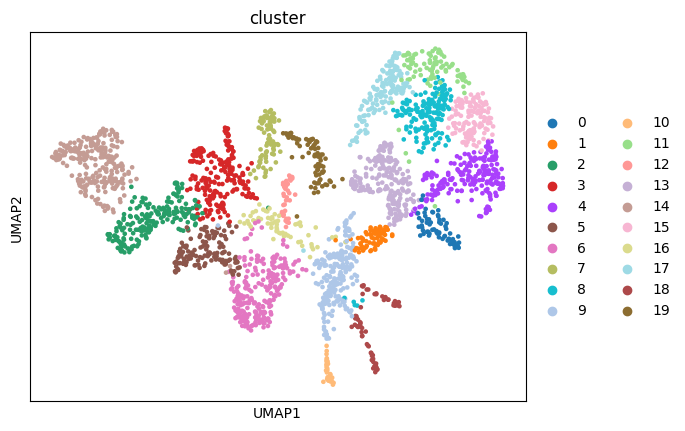

In [13]:
sc.pl.umap(adata1, color=["cluster"])

We could easily fill a whole, or multiple workshops on clustering and cell-type annotation. But we're going to use the pre-clustered dataset for the rest of this workshop. If would like a more in-depth explaination of clustering and cell-type annotation from marker genes or sets of differentially expressed genes, I would recommend starting here: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#manual-cell-type-annotation

### A couple other pre-processing steps...

The above is an overview of the main scanpy tools and preprocessing functions, but some other things you might want to do when starting from a raw count matrix are normalization and filtering so here are a couple of examples of what that might look like. And these steps would be done before calcuting neighbor graphs or clustering. 

#### Normalization

```python
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
```

#### Filtering

```python
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)
```


# Spatial Analysis and Visualization with Squidpy

Going back to the pre-processed adata object, we can visualize the cluster annotation with `sq.pl.spatial_scatter`.

These data have not only had the pre-processing steps above already completed, but also include spatial coordinates allowing us to do more spatial analysis, while the steps above would work for any single cell data.

In [24]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

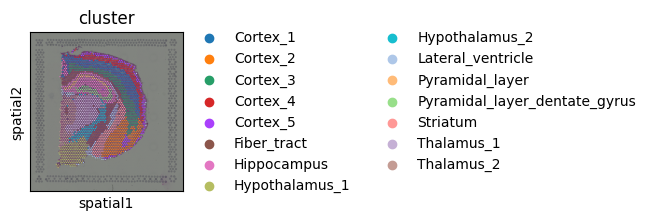

In [25]:
sq.pl.spatial_scatter(adata, color="cluster")

### Neighborhood Enrichment

In this context neighborhood enrichment is testing how often spots belonging to two different clusters are 'close' to each other connectivity matrix based on the spatial coordinates. Per the the Squidpy tutorial:

"Computing a neighborhood enrichment can help us identify spots clusters that share a common neighborhood structure across the tissue. We can compute such score with the following function: `squidpy.gr.nhood_enrichment()`. In short, it’s an enrichment score on spatial proximity of clusters: if spots belonging to two different clusters are often close to each other, then they will have a high score and can be defined as being enriched. On the other hand, if they are far apart, and therefore are seldom a neighborhood, the score will be low and they can be defined as depleted. This score is based on a permutation-based test, and you can set the number of permutations with the `n_perms` argument (default is 1000).

Since the function works on a connectivity matrix, we need to compute that as well. This can be done with `squidpy.gr.spatial_neighbors()`. Please see Building spatial neighbors graph for more details of how this function works: https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_spatial_neighbors.html

Finally, we’ll directly visualize the results with `squidpy.pl.nhood_enrichment()`."

  0%|          | 0/1000 [00:00<?, ?/s]

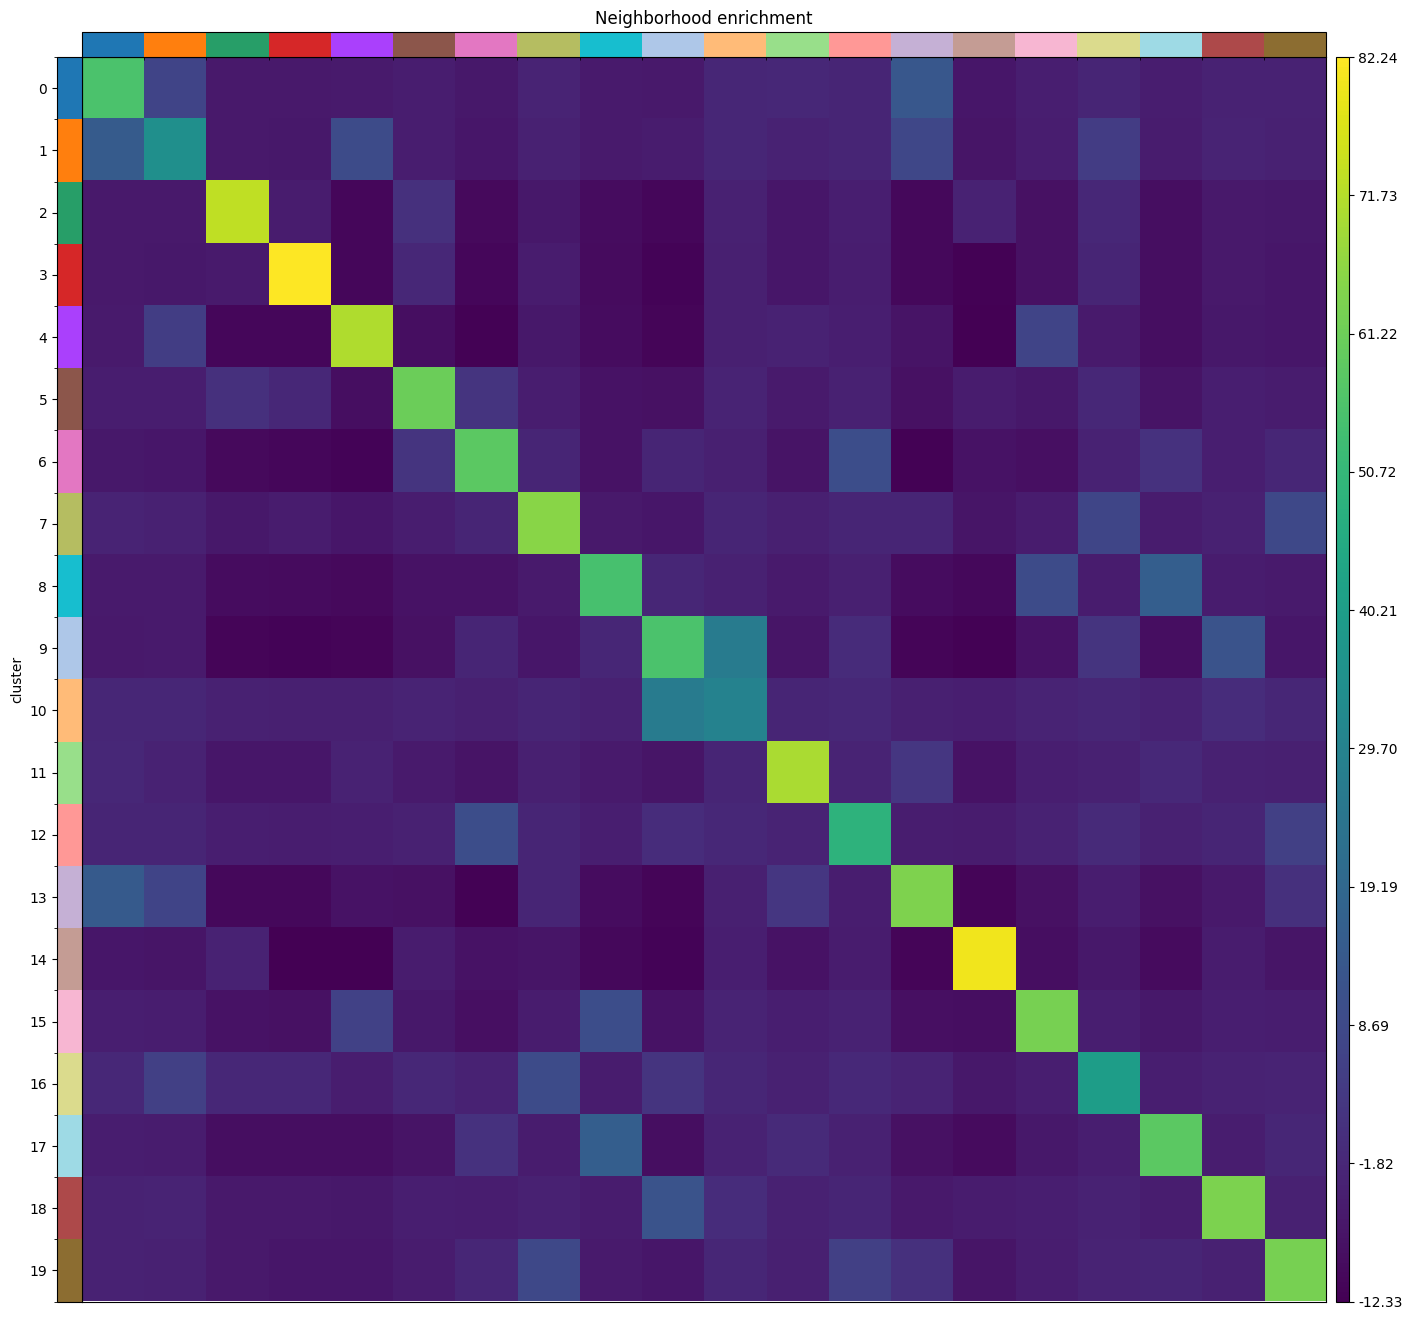

In [15]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

In [29]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [31]:
adata.uns["spatial_neighbors"]

{'connectivities_key': 'spatial_connectivities',
 'distances_key': 'spatial_distances',
 'params': {'n_neighbors': 6,
  'coord_type': 'grid',
  'radius': None,
  'transform': None}}

## Co-occurrence across spatial dimensions

"In addition to the neighbor enrichment score, we can visualize cluster co-occurrence in spatial dimensions. This is a similar analysis of the one presented above, yet it does not operate on the connectivity matrix, but on the original spatial coordinates. The co-occurrence score is defined as:

$$ \frac{p(exp|cond)}{p(exp)}
$$

where p(exp|cond)is the conditional probability of observing a cluster exp conditioned on the presence of a cluster 
cond, whereas p(exp)is the probability of observing exp in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

We can compute such score with `squidpy.gr.co_occurrence()` and set the cluster annotation for the conditional probability with the argument clusters. Then, we visualize the results with `squidpy.pl.co_occurrence()`."

  0%|          | 0/1 [00:00<?, ?/s]

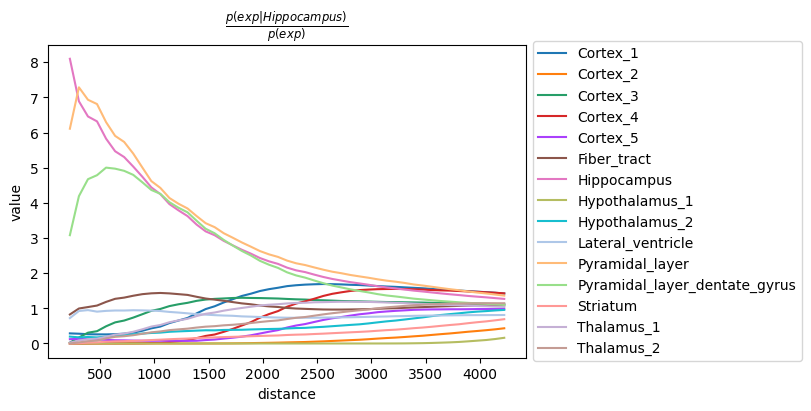

In [7]:
sq.gr.co_occurrence(adata, cluster_key="cluster")
sq.pl.co_occurrence(
    adata,
    cluster_key="cluster",
    clusters="Hippocampus",
    figsize=(8, 4),
)

## Spatially variable genes with Moran’s I

There are many ways to calculate which genes show spatial patterns and there is a good list of approaches at the end of this tutorial: https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_visium_hne.html#spatial-statistics-and-graph-analysis

But one way, which they also use as an example in the tutorial above, is Moran's I which is a measure of spatial autocorrelation, or whether values of a variable are clustered, dispersed or random across a geographic space. Values significantly below -1/(N-1) indicate negative spatial autocorrelation (nearby locations have dissimilar values) and values significantly above -1/(N-1) indicate positive spatial autocorrelation (nearby locations have similar values). For statistical hypothesis testing, Moran's I values can be transformed to z-scores.

In [14]:
genes = adata[:, adata.var.highly_variable].var_names.values[:1000]
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [15]:
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Olfm1,0.763291,0.0,0.000131,0.0,0.009901,0.000345,0.0,0.0,0.011621
Plp1,0.747660,0.0,0.000131,0.0,0.009901,0.000259,0.0,0.0,0.011621
Itpka,0.727076,0.0,0.000131,0.0,0.009901,0.000302,0.0,0.0,0.011621
Snap25,0.720987,0.0,0.000131,0.0,0.009901,0.000275,0.0,0.0,0.011621
Nnat,0.708637,0.0,0.000131,0.0,0.009901,0.000259,0.0,0.0,0.011621
Ppp3ca,0.693320,0.0,0.000131,0.0,0.009901,0.000329,0.0,0.0,0.011621
Chn1,0.684957,0.0,0.000131,0.0,0.009901,0.000259,0.0,0.0,0.011621
Mal,0.679775,0.0,0.000131,0.0,0.009901,0.000213,0.0,0.0,0.011621
Tmsb4x,0.676719,0.0,0.000131,0.0,0.009901,0.000284,0.0,0.0,0.011621
Cldn11,0.674110,0.0,0.000131,0.0,0.009901,0.000213,0.0,0.0,0.011621


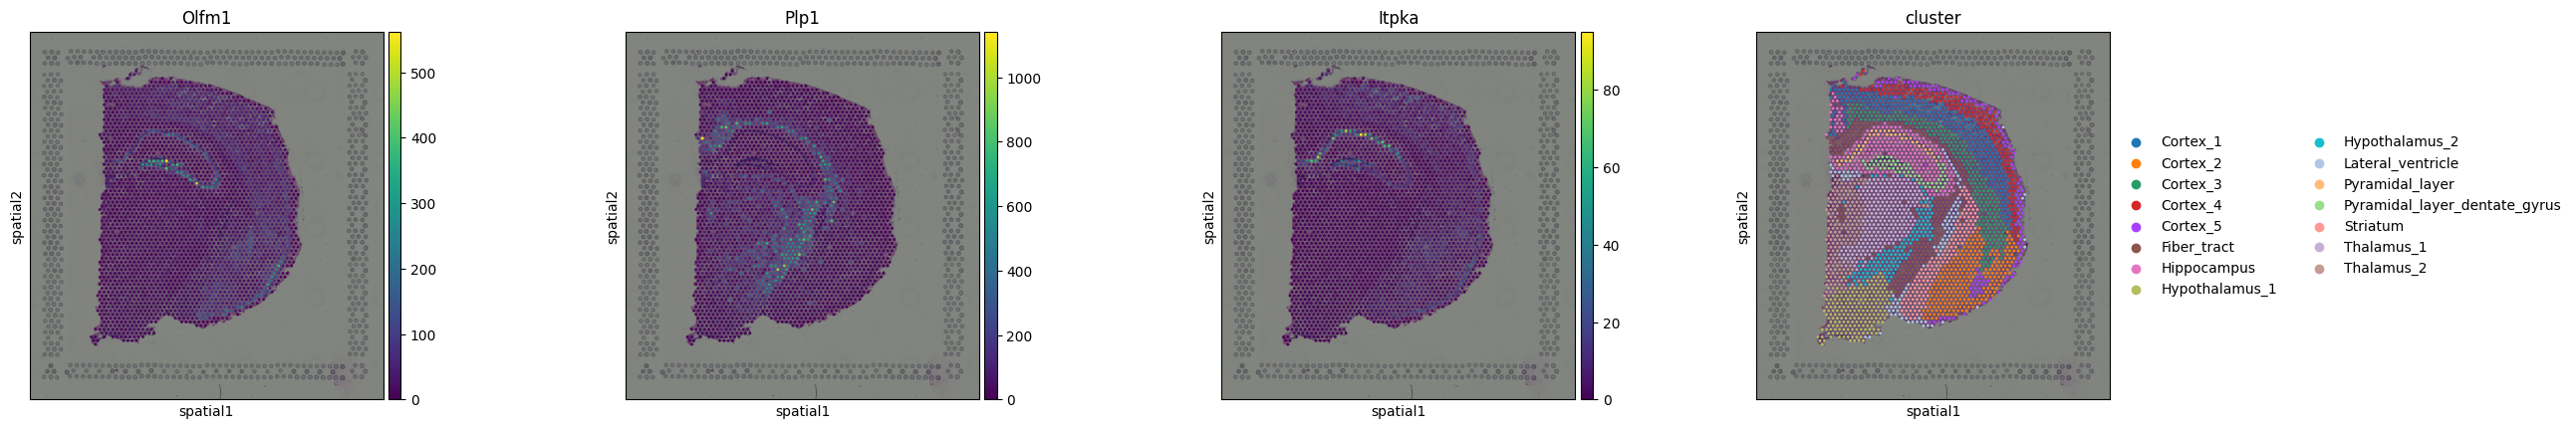

In [16]:
sq.pl.spatial_scatter(adata, color=["Olfm1", "Plp1", "Itpka", "cluster"])